In [1]:
import itertools
import random

import torch
from torch.nn import Linear
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_scatter import scatter_mean
from collections import defaultdict

from custom.args import grey, purple
from custom.dataset import GraphDataset, create_dataset
from custom.utils import *
from networkx.algorithms.centrality import degree_centrality
import pickle
from itertools import zip_longest
from torch_geometric.utils import degree

from custom.utils import *

In [2]:
import networkx as nx
import torch
from torch_geometric.utils import degree
import time


class MCS:
    def __init__(self, mp):
        self.mp = mp
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.visited = set()
        self.time_limit = 5
        self.start_time = None

    def find_mcs(self, G1, G2):
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.visited = set()
        self.start_time = time.time()

        G1_degrees = degree(G1.edge_index[0], G1.num_nodes)
        G2_degrees = degree(G2.edge_index[0], G2.num_nodes)

        nodes1 = list(range(G1.num_nodes))
        nodes2 = list(range(G2.num_nodes))

        for n1 in nodes1:
            for n2 in nodes2:
                if (n1, n2) in self.mp:
                    M = {n1: n2}
                    neighbors1 = set(G1.edge_index[1][G1.edge_index[0] == n1].tolist())
                    neighbors2 = set(G2.edge_index[1][G2.edge_index[0] == n2].tolist())
                    self.match(
                        G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2
                    )
        return self.all_mappings

    def match(self, G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2):
        if time.time() - self.start_time > self.time_limit:
            return

        state = (frozenset(M.items()), frozenset(neighbors1), frozenset(neighbors2))
        if state in self.visited:
            return
        self.visited.add(state)

        edge_count = self.count_edges(M, G1, G2)

        if len(M) > self.max_size or (
            len(M) == self.max_size and edge_count > self.edge_count
        ):
            self.max_size = len(M)
            self.edge_count = edge_count
            self.all_mappings = [M.copy()]
            self.unique_mappings = {self.canonical_form(M)}
        elif len(M) == self.max_size and edge_count == self.edge_count:
            canonical = self.canonical_form(M)
            if canonical not in self.unique_mappings:
                self.all_mappings.append(M.copy())
                self.unique_mappings.add(canonical)

        candidates1 = sorted(neighbors1, key=lambda n: -G1_degrees[n].item())
        candidates2 = sorted(neighbors2, key=lambda n: -G2_degrees[n].item())

        for n1 in candidates1:
            if n1 not in M:
                for n2 in candidates2:
                    if n2 not in M.values() and self.feasible(n1, n2, M, G1, G2):
                        M[n1] = n2
                        new_neighbors1 = set(
                            G1.edge_index[1][G1.edge_index[0] == n1].tolist()
                        )
                        new_neighbors2 = set(
                            G2.edge_index[1][G2.edge_index[0] == n2].tolist()
                        )
                        neighbors1.update(new_neighbors1 - set(M.keys()))
                        neighbors2.update(new_neighbors2 - set(M.values()))
                        self.match(
                            G1,
                            G2,
                            M,
                            G1_degrees,
                            G2_degrees,
                            neighbors1,
                            neighbors2,
                        )
                        del M[n1]
                        neighbors1.difference_update(new_neighbors1)
                        neighbors2.difference_update(new_neighbors2)

    def feasible(self, n1, n2, M, G1, G2):
        if not torch.equal(G1.x[n1], G2.x[n2]):
            return False
        if (n1, n2) not in self.mp:
            return False

        count1 = 0
        count2 = 0

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if neighbor.item() in M:
                count1 += 1

        for neighbor in G2.edge_index[1][G2.edge_index[0] == n2]:
            if neighbor.item() in M.values():
                count2 += 1

        if count1 != count2:
            return False

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if (
                neighbor.item() in M
                and not (
                    G2.edge_index[1][G2.edge_index[0] == n2] == M[neighbor.item()]
                ).any()
            ):
                return False

        return True

    def count_edges(self, M, G1, G2):
        edge_count = 0
        for u1, v1 in M.items():
            for u2, v2 in M.items():
                if u1 != u2:
                    u1_v1_exists = (
                        (G1.edge_index[0] == u1) & (G1.edge_index[1] == u2)
                    ).any() or (
                        (G1.edge_index[0] == u2) & (G1.edge_index[1] == u1)
                    ).any()
                    u2_v2_exists = (
                        (G2.edge_index[0] == v1) & (G2.edge_index[1] == v2)
                    ).any() or (
                        (G2.edge_index[0] == v2) & (G2.edge_index[1] == v1)
                    ).any()
                    if u1_v1_exists and u2_v2_exists:
                        edge_count += 1
        return edge_count

    def canonical_form(self, M):
        G1_set = set(M.keys())
        G2_set = set(M.values())
        return (frozenset(G1_set), frozenset(G2_set))

In [40]:
def plot_attentions(graph1, graph2, attention_pairs, title=""):
    def get_node_labels(graph):
        node_labels = {}
        for node in range(graph.num_nodes):
            node_labels[node] = node
        return node_labels

    G1 = to_networkx(graph1, to_undirected=True)
    G2 = to_networkx(graph2, to_undirected=True)

    G_combined = nx.Graph()

    for n, d in G1.nodes(data=True):
        G_combined.add_node(n, **d)
    for n, d in G2.nodes(data=True):
        G_combined.add_node(n + len(G1.nodes), **d)

    G_combined.add_edges_from([(u, v) for u, v in G1.edges()])
    G_combined.add_edges_from(
        [(u + len(G1.nodes), v + len(G1.nodes)) for u, v in G2.edges()]
    )

    G_plain = G_combined.copy()

    for node1, node2 in attention_pairs:
        G_combined.add_edge(node1, node2 + len(G1.nodes))

    pos_G1 = nx.spring_layout(G1)
    pos_G2 = nx.spring_layout(G2)

    for key in pos_G1.keys():
        pos_G1[key] = [pos_G1[key][0] - 1.5, pos_G1[key][1]]

    for key in pos_G2.keys():
        pos_G2[key] = [pos_G2[key][0] + 1.5, pos_G2[key][1]]

    pos_combined = {**pos_G1, **{k + len(G1.nodes): v for k, v in pos_G2.items()}}

    node_labels_G1 = get_node_labels(graph1)
    node_labels_G2 = get_node_labels(graph2)
    node_labels_combined = {
        **node_labels_G1,
        **{k + len(G1.nodes): v for k, v in node_labels_G2.items()},
    }

    plt.figure(figsize=(12, 6))
    plt.gcf().patch.set_alpha(0)

    nx.draw(
        G_plain,
        pos=pos_combined,
        with_labels=False,
        labels=node_labels_combined,
        node_color="#3b8bc2",
        edge_color="black",
        node_size=500,
    )

    # attention_edges = [
    #     (node1, node2 + len(G1.nodes)) for node1, node2 in attention_pairs
    # ]
    # nx.draw_networkx_edges(
    #     G_combined,
    #     pos=pos_combined,
    #     edgelist=attention_edges,
    #     edge_color="lightgrey",
    # )

    plt.title(title)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.gcf().patch.set_alpha(0)

    nx.draw(
        G_combined,
        pos=pos_combined,
        with_labels=False,
        labels=node_labels_combined,
        node_color="#3b8bc2",
        edge_color="black",
        node_size=500,
    )

    attention_edges = [
        (node1, node2 + len(G1.nodes)) for node1, node2 in attention_pairs
    ]
    nx.draw_networkx_edges(
        G_combined,
        pos=pos_combined,
        edgelist=attention_edges,
        edge_color="lightgrey",
    )

    plt.title(title)
    plt.show()

In [73]:
def loop(graph1, graph2, attentions, t):
    most_nodes = 0
    largest_summary = None
    for i in range(7):
        attention_nodes = extract_dynamic_attention_nodes(attentions, threshold=t)
        mp = mutual_pairs(attention_nodes, i)
        vf2 = MCS(mp)
        patterns = vf2.find_mcs(graph1, graph2)

        if patterns != []:
            pattern = patterns[0]

            g1_subgraph, g2_subgraph = create_subgraphs(pattern, graph1, graph2)

            if (
                nx.is_isomorphic(
                    to_networkx(g1_subgraph, to_undirected=True),
                    to_networkx(g2_subgraph, to_undirected=True),
                )
                and len(pattern) > 2
            ):
                summary = Data(
                    x=(g1_subgraph.x + g2_subgraph.x) / 2,
                    edge_index=g1_subgraph.edge_index,
                )

                if len(pattern) > most_nodes:
                    most_nodes = len(pattern)
                    largest_summary = summary
                    print(i)

    return largest_summary

0


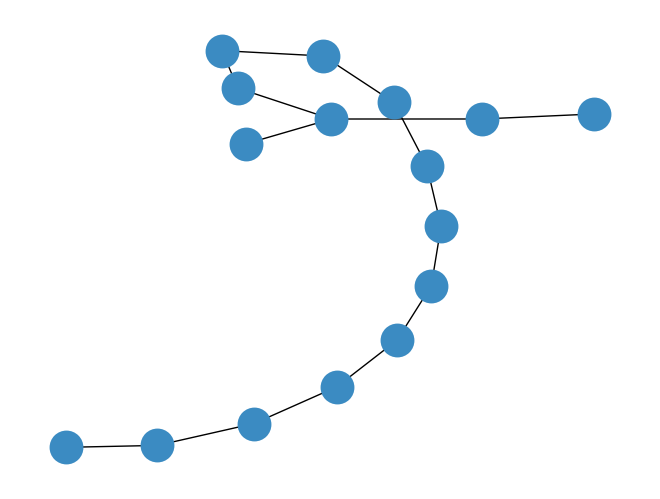

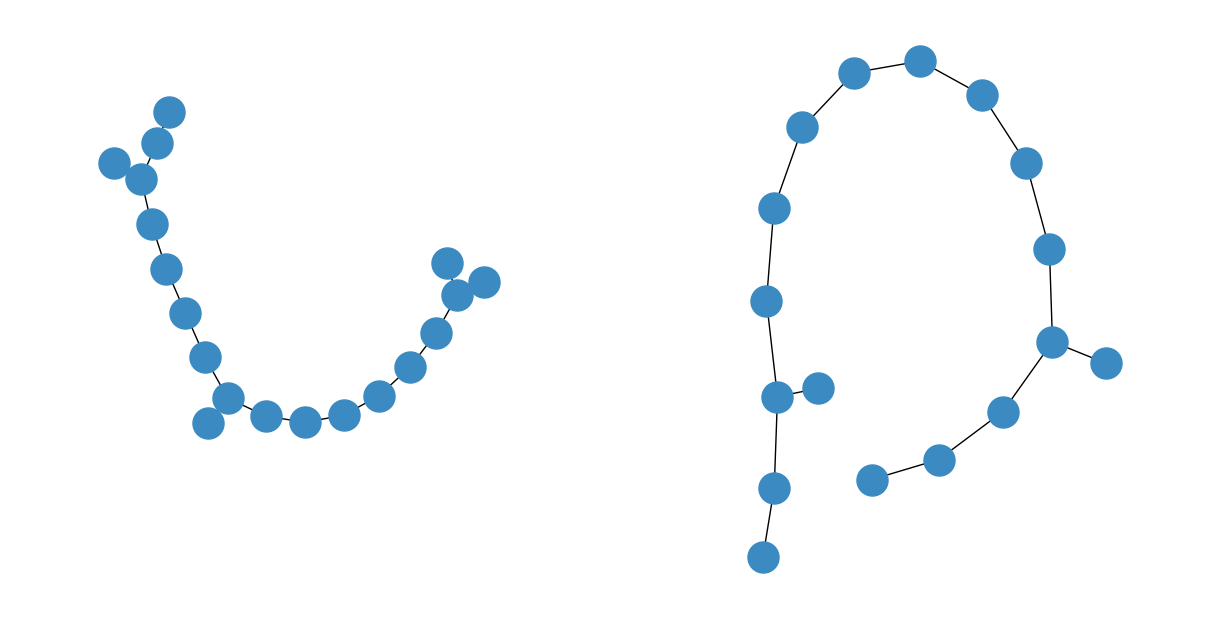

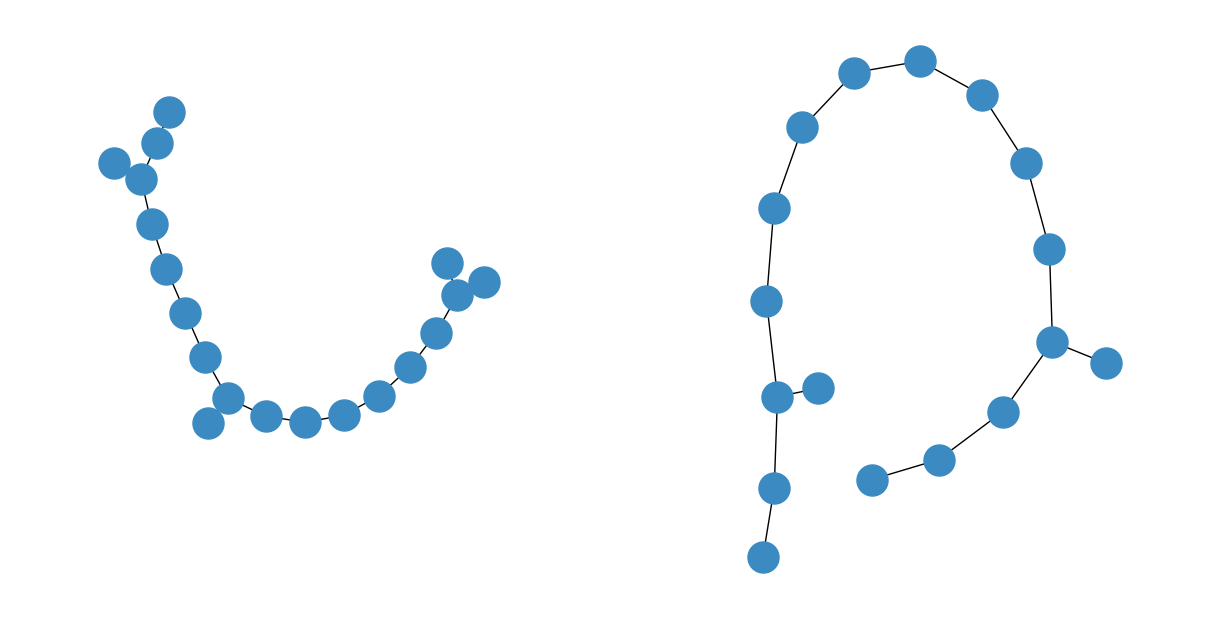

16


In [85]:
(graph1, graph2, attentions) = torch.load("method2_incorrect_example_line_15.pt")

summary = loop(graph1, graph2, attentions, 0.05)

nx_graph1 = to_networkx(graph1, to_undirected=True)
nx_graph2 = to_networkx(graph2, to_undirected=True)
ismags = nx.isomorphism.ISMAGS(nx_graph1, nx_graph2)

# largest_common_subgraph = list(ismags.largest_common_subgraph())

# plot_graph(create_subgraphs(largest_common_subgraph[0], graph1, graph2)[0])

plot_graph(summary)

attention_nodes = extract_dynamic_attention_nodes(attentions, threshold=0.1)
mp = mutual_pairs(attention_nodes, 3)
vf2 = MCS(mp)
plot_attentions(graph1, graph2, mp)

print(summary.num_nodes)

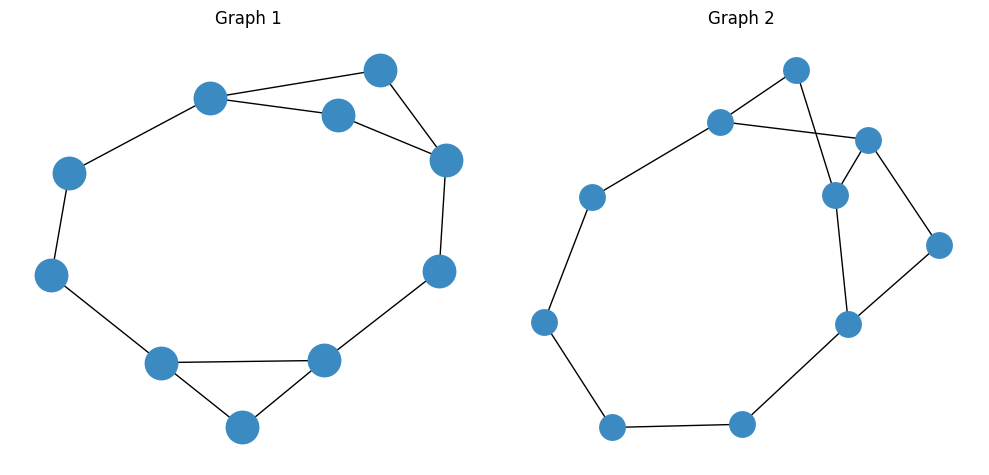

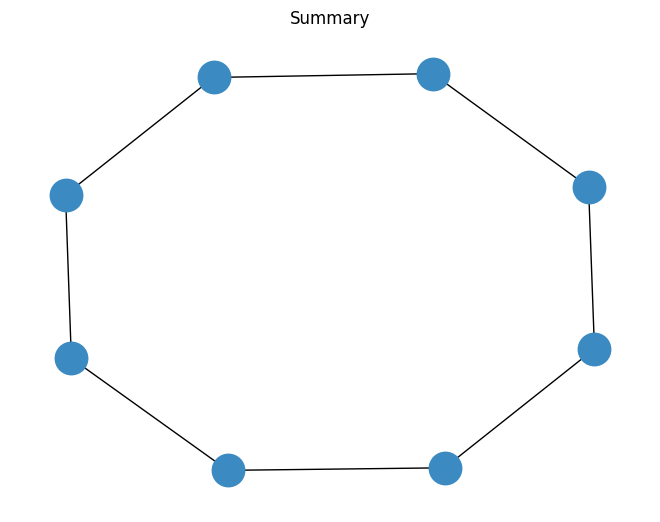

In [31]:
plot_graph_pair(graph1, graph2, "Graph 1", "Graph 2")
plot_graph(summary, "Summary")